In [11]:
import cv2
import os
import numpy as np
import pickle
import optuna
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import utils

In [30]:
train_labels = pickle.load(open('train_labels.dat','rb')) 
test_labels = pickle.load(open('test_labels.dat','rb'))

In [12]:
codebooks_folder = "Task2/pickles"
os.makedirs(codebooks_folder, exist_ok=True)

train_descriptors = pickle.load(open(f'{codebooks_folder}/training_features.dat', 'rb'))
test_descriptors = pickle.load(open(f'{codebooks_folder}/test_features.dat', 'rb'))

### K-Means clustering
We now compute a k-means clustering on the descriptor space

In [13]:
def kmeans(k, train_descriptors):
    codebook, d_codebook = None, None
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20, compute_labels=False, reassignment_ratio=10**-4, random_state=42)
    codebook.fit(train_descriptors)        
    return codebook

k = 192
codebook = kmeans(k, train_descriptors)

c:\Users\maria\Desktop\C3\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


### Create Training Visual words for BOVW


In [27]:
def get_train_visual_words(train_descriptors, codebook):
    visual_words = None
    visual_words = np.zeros((len(train_descriptors), k), dtype=np.float32)

    for i in range(len(train_descriptors)):
        descriptor = train_descriptors[i].reshape(1, -1)
        words = codebook.predict(descriptor)
        visual_words[i,:] = np.bincount(words, minlength=k)
    
    return visual_words

visual_words = \
    get_train_visual_words(
        train_descriptors,
        codebook
    )


(1, 128)


### Create Test Visual words for BOVW


In [28]:
visual_words_test = \
    get_train_visual_words(
        test_descriptors,
        codebook
    )

(1, 128)


------------------------------------------------------------------------------------------------------------------------------------------------

### Experimentation
This section is just for testing purposes. In here, we can store different values for different experiments for later use.

In case we want to try with standard scaling.

------------------------------------------------------------------------------------------------------------------------------------------------

### K-NN Classifier
We build a k-nn classifier and train it with the train descriptors

In [41]:
knn = KNeighborsClassifier(n_neighbors=10, n_jobs=-1, metric='euclidean')
knn.fit(visual_words, train_labels) 
base_knn = knn

Optuna to test different values for k in kmeans

C:\Users\maria\AppData\Local\Temp\ipykernel_16072\1894574369.py:5: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(loaded_study)
[W 2024-01-05 15:06:52,654] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


Best Hyperparameters: {'k_means_clusters': 192, 'knn_distance_metric': 'euclidean', 'knn_neighbors': 10}


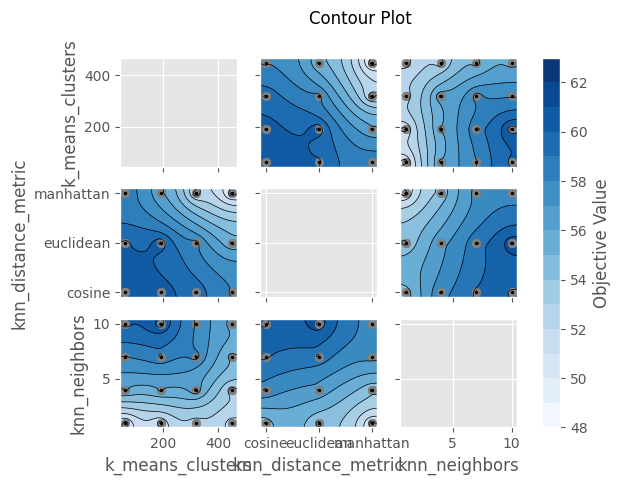

In [ ]:
# Load the existing study from the database
loaded_study = optuna.load_study(
    study_name="a11111", storage="sqlite:///hparam.db"
)
optuna.visualization.matplotlib.plot_contour(loaded_study)

# Get the best hyperparameters
best_params = loaded_study.best_params
print("Best Hyperparameters:", best_params)

In [33]:
accuracy = 100*knn.score(visual_words_test, test_labels)
print(f"SIFT accuracy: {accuracy}")


SIFT accuracy: 13.878562577447337


#### Dimensionality reduction, with PCA and LDA

We will use this auxiliar function in every model to make it easier to test different models.

In [34]:
def apply_dimensionality_reduction_and_classification(X_train, X_test, train_labels, test_labels, reduction_method, model):
    if reduction_method == 'pca':
        reducer = PCA(n_components=64)
    elif reduction_method == 'lda':
        reducer = LinearDiscriminantAnalysis(n_components=7)
    else:
        raise ValueError("Invalid reduction method. Use 'pca' or 'lda'.")

    X_train_reduced = reducer.fit_transform(X_train, train_labels)
    X_test_reduced = reducer.transform(X_test)

    model.fit(X_train_reduced, train_labels)

    # Make predictions on the test data
    predictions = model.predict(X_test_reduced)

    # Calculate the accuracy
    accuracy = accuracy_score(test_labels, predictions)
    print(f"    -> Accuracy ({reduction_method.upper()}): {accuracy * 100:.2f}%")


##### PCA
PCA aims to maximize the variance in the data. It tends to capture global structures and patterns in the data, but it might not preserve class-specific information well. It might mix information from different classes, leading to reduced discriminative power. That could be the reason for the reduction in accuracy obtained after applying PCA to our problem.

In [35]:
# Apply PCA and KNN for standard descriptors

print('PCA and KNN for standard descriptors:')
apply_dimensionality_reduction_and_classification(visual_words, visual_words_test, train_labels, test_labels, 'pca', model=KNeighborsClassifier(n_neighbors=10,n_jobs=-1,metric='euclidean'))


PCA and KNN for standard descriptors:
    -> Accuracy (PCA): 13.88%


##### LDA
LDA considers class information during dimensionality reduction. It aims to maximize the distance between class means while minimizing the spread within each class. This can lead to better separation between classes. Since our data has a clear class structure, LDA is more effective and improves the accuracy to our problem.

In [36]:
# Apply LDA and KNN for standard descriptors

print('PCA and KNN for standard descriptors:')
apply_dimensionality_reduction_and_classification(visual_words, visual_words_test, train_labels, test_labels, 'lda', model=KNeighborsClassifier(n_neighbors=10,n_jobs=-1,metric='euclidean'))

PCA and KNN for standard descriptors:
    -> Accuracy (LDA): 15.86%


#### Cross validation

In [37]:
# Perform cross-validation
cv_scores_knn = cross_val_score(knn, visual_words, train_labels, cv=5) 

# Print the cross-validation scores
print("KNN Cross-Validation Scores:")
print(cv_scores_knn)
print(f"Mean Accuracy: {np.mean(cv_scores_knn) * 100:.2f}%")


KNN Cross-Validation Scores:
[0.13793103 0.1356383  0.13297872 0.12234043 0.1356383 ]
Mean Accuracy: 13.29%


Cross-Validate all KNN combinations:

In [ ]:
print("\nMean cross-validation SIFT + KNN + L2 Norm:", f"{np.mean(cross_val_score(knn, visual_words_test_l2, test_labels, cv=5))*100:.2f}%")
print("\nMean cross-validation Dense SIFT + KNN + L2 Norm:", f"{np.mean(cross_val_score(d_knn, visual_words_dense_test_l2, test_labels, cv=5))*100:.2f}%")
print("\nMean cross-validation SIFT + KNN + Standard Scaling:", f"{np.mean(cross_val_score(knn, visual_words_test_std_scaling, test_labels, cv=5))*100:.2f}%")
print("\nMean cross-validation Dense SIFT + KNN + Standard Scaling:", f"{np.mean(cross_val_score(d_knn, visual_words_dense_test_std_scaling, test_labels, cv=5))*100:.2f}%")
print("\nMean cross-validation SIFT + KNN + Spatial Pyramid:", f"{np.mean(cross_val_score(knn, test_descriptors_sp, test_labels, cv=5))*100:.2f}%")
print("\nMean cross-validation Dense SIFT + KNN + Spatial Pyramid:", f"{np.mean(cross_val_score(d_knn, test_descriptors_sp_dense, test_labels, cv=5))*100:.2f}%")


Mean cross-validation SIFT + KNN + L2 Norm: 51.05%

Mean cross-validation Dense SIFT + KNN + L2 Norm: 72.00%

Mean cross-validation SIFT + KNN + Standard Scaling: 53.66%

Mean cross-validation Dense SIFT + KNN + Standard Scaling: 73.11%

Mean cross-validation SIFT + KNN + Spatial Pyramid: 49.32%

Mean cross-validation Dense SIFT + KNN + Spatial Pyramid: 78.44%


### Experimentation with KNN

Confusion Matrix (SIFT):


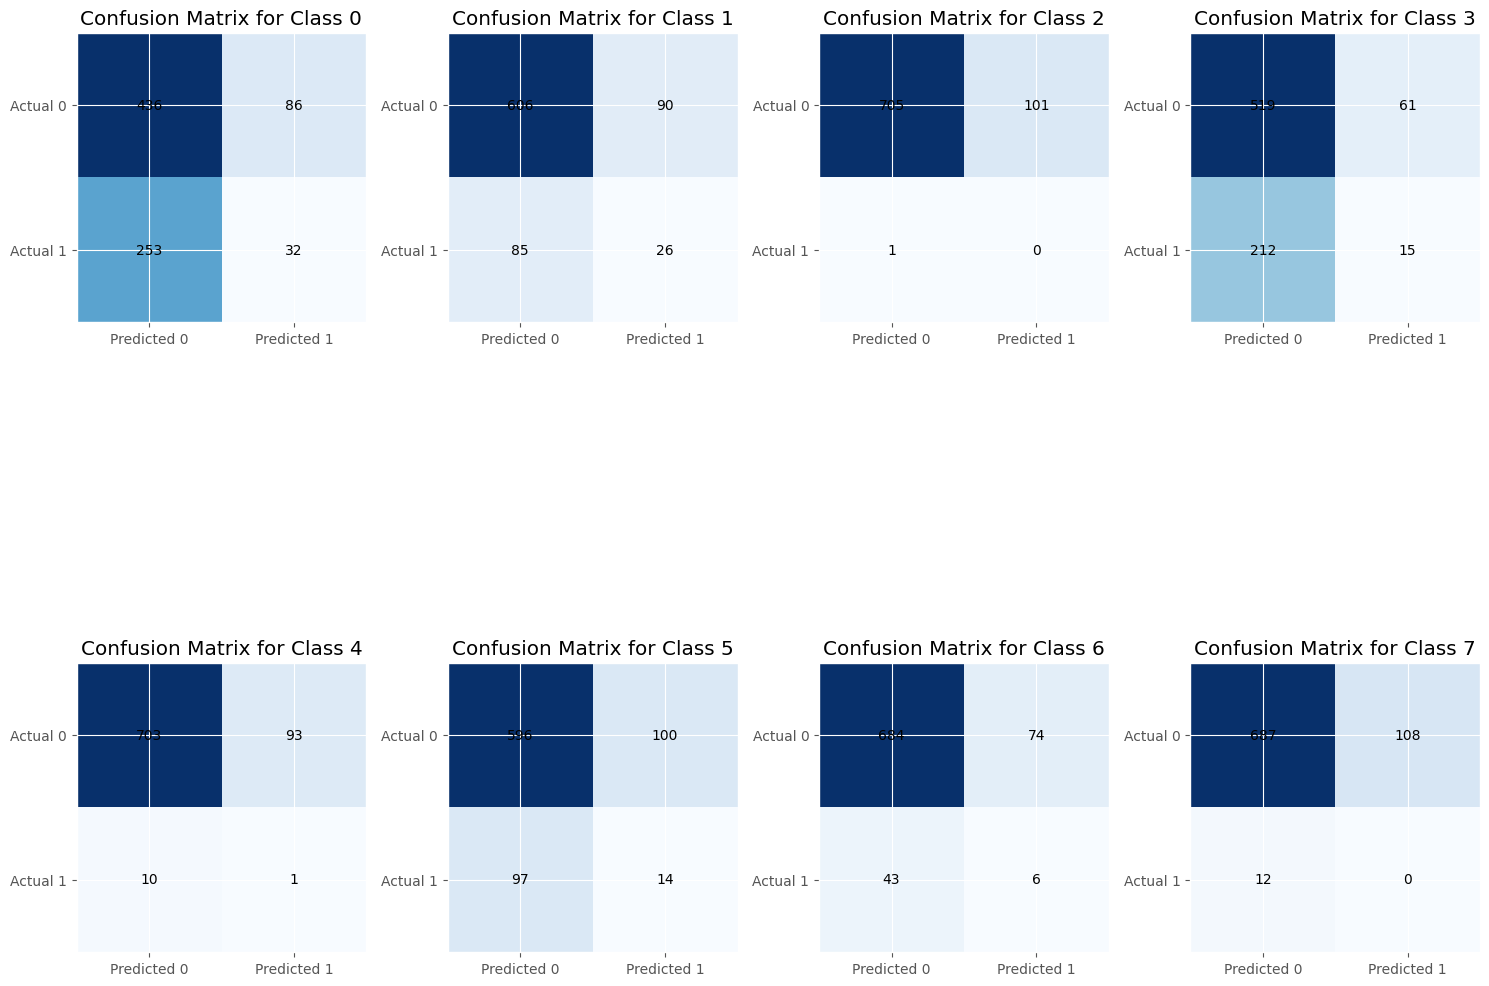

Confusion Matrix (Dense SIFT):


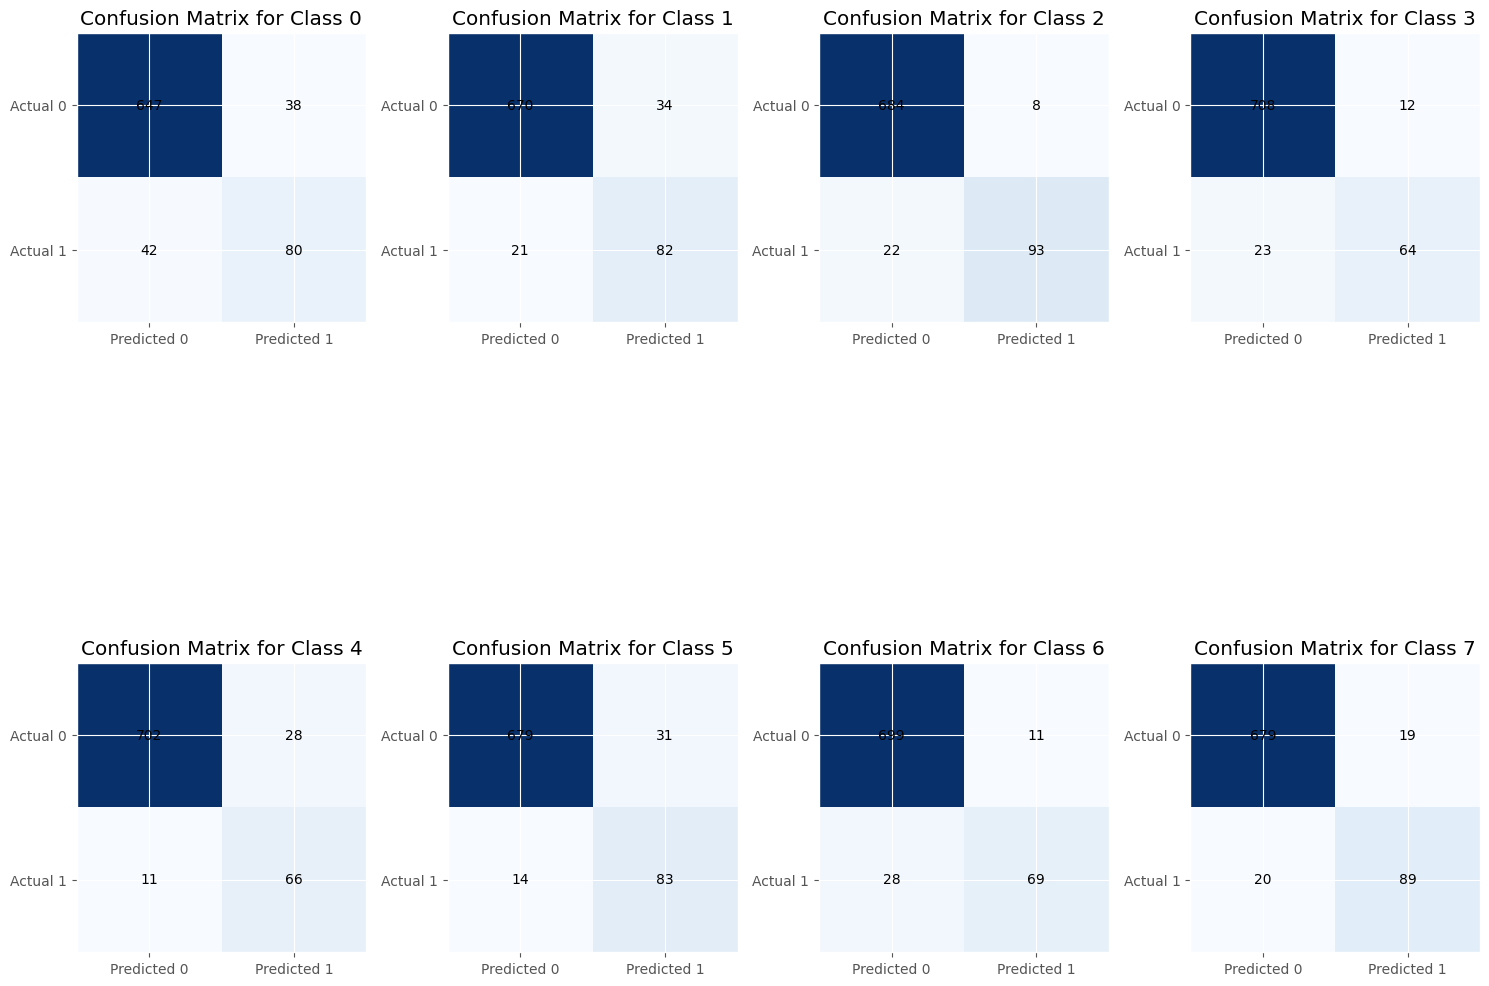

In [ ]:
print("Confusion Matrix (SIFT):")
utils.display_multilabel_confusion_matrix(visual_words_dense_test, test_labels, knn)

print("Confusion Matrix (Dense SIFT):")
utils.display_multilabel_confusion_matrix(visual_words_dense_test, test_labels, d_knn)

In [42]:
report = classification_report(knn.predict(visual_words_test), test_labels)
print("Classification Report (SIFT):\n", report)

Classification Report (SIFT):
               precision    recall  f1-score   support

 Opencountry       0.59      0.15      0.24       468
       coast       0.16      0.13      0.15       141
      forest       0.13      0.17      0.15        78
     highway       0.03      0.04      0.03        48
 inside_city       0.01      0.03      0.02        32
    mountain       0.04      0.26      0.08        19
      street       0.01      0.07      0.02        14
tallbuilding       0.01      0.14      0.02         7

    accuracy                           0.14       807
   macro avg       0.12      0.13      0.09       807
weighted avg       0.39      0.14      0.18       807



In [ ]:
report = classification_report(d_knn.predict(visual_words_dense_test), test_labels)
print("Classification Report (Dense SIFT):\n", report)

Classification Report (Dense SIFT):
               precision    recall  f1-score   support

 Opencountry       0.68      0.66      0.67       122
       coast       0.71      0.80      0.75       103
      forest       0.92      0.81      0.86       115
     highway       0.84      0.74      0.79        87
 inside_city       0.70      0.86      0.77        77
    mountain       0.73      0.86      0.79        97
      street       0.86      0.71      0.78        97
tallbuilding       0.82      0.82      0.82       109

    accuracy                           0.78       807
   macro avg       0.78      0.78      0.78       807
weighted avg       0.78      0.78      0.78       807



In [ ]:
print("SIFT + KNN + L2 Norm")
utils.fit_predict_and_score(knn, visual_words_l2, train_labels, visual_words_test_l2, test_labels)
print("\nDense SIFT + KNN + L2 Norm")
utils.fit_predict_and_score(d_knn, visual_words_dense_l2, train_labels, visual_words_dense_test_l2, test_labels)
print("\nSIFT + KNN + L2 Norm + PCA")
apply_dimensionality_reduction_and_classification(visual_words_l2, visual_words_test_l2, train_labels, test_labels, 'pca', model=knn)
print("\nDense SIFT + KNN + L2 Norm + PCA")
apply_dimensionality_reduction_and_classification(visual_words_dense_l2, visual_words_dense_test_l2, train_labels, test_labels, 'pca', model=d_knn)
print("\nSIFT + KNN + L2 Norm + LDA")
apply_dimensionality_reduction_and_classification(visual_words_l2, visual_words_test_l2, train_labels, test_labels, 'lda', model=knn)
print("\nDense SIFT + KNN + L2 Norm + LDA")
apply_dimensionality_reduction_and_classification(visual_words_dense_l2, visual_words_dense_test_l2, train_labels, test_labels, 'lda', model=d_knn)

SIFT + KNN + L2 Norm
    -> F1-Score: 55.78%
    -> Accuracy: 56.75%
    -> Precision: 58.45%
    -> Recall: 57.88%

Dense SIFT + KNN + L2 Norm
    -> F1-Score: 76.44%
    -> Accuracy: 76.33%
    -> Precision: 76.55%
    -> Recall: 77.04%

SIFT + KNN + L2 Norm + PCA
    -> Accuracy (PCA): 56.26%

Dense SIFT + KNN + L2 Norm + PCA
    -> Accuracy (PCA): 77.32%

SIFT + KNN + L2 Norm + LDA
    -> Accuracy (LDA): 65.55%

Dense SIFT + KNN + L2 Norm + LDA
    -> Accuracy (LDA): 82.16%


In [ ]:
print("SIFT + KNN + Standard Scaling")
utils.fit_predict_and_score(knn, visual_words_std_scaling, train_labels, visual_words_test_std_scaling, test_labels)
print("\nDense SIFT + KNN + Standard Scaling")
utils.fit_predict_and_score(d_knn, visual_words_dense_std_scaling, train_labels, visual_words_dense_test_std_scaling, test_labels)
print("\nSIFT + KNN + Standard Scaling + PCA")
apply_dimensionality_reduction_and_classification(visual_words_std_scaling, visual_words_test_std_scaling, train_labels, test_labels, 'pca', model=knn)
print("\nDense SIFT + KNN + Standard Scaling + PCA")
apply_dimensionality_reduction_and_classification(visual_words_dense_std_scaling, visual_words_dense_test_std_scaling, train_labels, test_labels, 'pca', model=d_knn)
print("\nSIFT + KNN + Standard Scaling + LDA")
apply_dimensionality_reduction_and_classification(visual_words_std_scaling, visual_words_test_std_scaling, train_labels, test_labels, 'lda', model=knn)
print("\nDense SIFT + KNN + Standard Scaling + LDA")
apply_dimensionality_reduction_and_classification(visual_words_dense_std_scaling, visual_words_dense_test_std_scaling, train_labels, test_labels, 'lda', model=d_knn)

SIFT + KNN + Standard Scaling
    -> F1-Score: 60.92%
    -> Accuracy: 61.46%
    -> Precision: 63.13%
    -> Recall: 61.41%

Dense SIFT + KNN + Standard Scaling
    -> F1-Score: 79.16%
    -> Accuracy: 79.18%
    -> Precision: 79.14%
    -> Recall: 79.90%

SIFT + KNN + Standard Scaling + PCA
    -> Accuracy (PCA): 63.32%

Dense SIFT + KNN + Standard Scaling + PCA
    -> Accuracy (PCA): 77.94%

SIFT + KNN + Standard Scaling + LDA
    -> Accuracy (LDA): 64.44%

Dense SIFT + KNN + Standard Scaling + LDA
    -> Accuracy (LDA): 82.78%


In [ ]:
print("SIFT + KNN + Spatial Pyramid")
utils.fit_predict_and_score(knn, train_descriptors_sp, train_labels, test_descriptors_sp, test_labels)
print("\nDense SIFT + KNN + Spatial Pyramid")
utils.fit_predict_and_score(d_knn, train_descriptors_sp_dense, train_labels, test_descriptors_sp_dense, test_labels)
print("\nSIFT + KNN + Spatial Pyramid + PCA")
apply_dimensionality_reduction_and_classification(train_descriptors_sp, test_descriptors_sp, train_labels, test_labels, 'pca', model=knn)
print("\nDense SIFT + KNN + Spatial Pyramid + PCA")
apply_dimensionality_reduction_and_classification(train_descriptors_sp_dense, test_descriptors_sp_dense, train_labels, test_labels, 'pca', model=d_knn)
print("\nSIFT + KNN + Spatial Pyramid + LDA")
apply_dimensionality_reduction_and_classification(train_descriptors_sp, test_descriptors_sp, train_labels, test_labels, 'lda', model=knn)
print("\nDense SIFT + KNN + Spatial Pyramid + LDA")
apply_dimensionality_reduction_and_classification(train_descriptors_sp_dense, test_descriptors_sp_dense, train_labels, test_labels, 'lda', model=d_knn)

SIFT + KNN + Spatial Pyramid
    -> F1-Score: 54.93%
    -> Accuracy: 55.39%
    -> Precision: 61.12%
    -> Recall: 54.48%

Dense SIFT + KNN + Spatial Pyramid
    -> F1-Score: 79.37%
    -> Accuracy: 78.93%
    -> Precision: 79.98%
    -> Recall: 79.82%

SIFT + KNN + Spatial Pyramid + PCA
    -> Accuracy (PCA): 66.05%

Dense SIFT + KNN + Spatial Pyramid + PCA
    -> Accuracy (PCA): 78.56%

SIFT + KNN + Spatial Pyramid + LDA
    -> Accuracy (LDA): 28.13%

Dense SIFT + KNN + Spatial Pyramid + LDA
    -> Accuracy (LDA): 54.65%


##### ROC curves for each class

ROC Curve (SIFT):


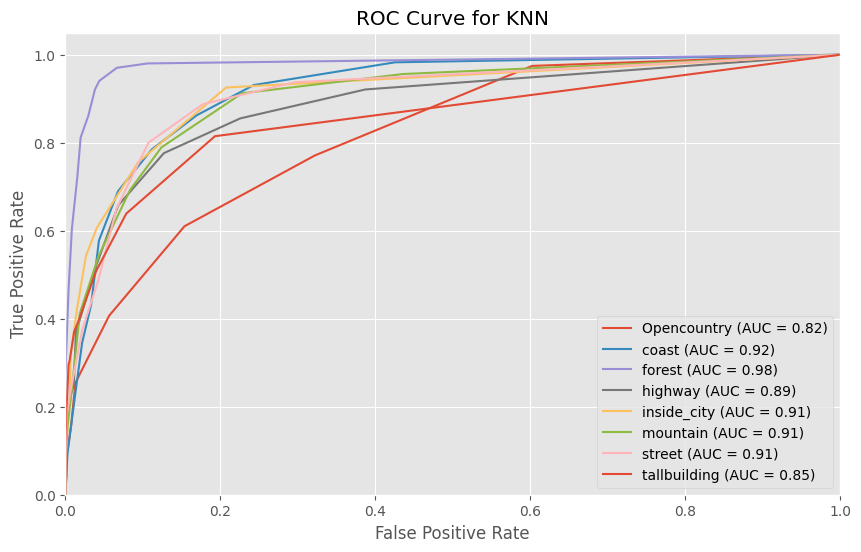

In [ ]:
print("ROC Curve (SIFT):")
utils.plot_roc_curve(visual_words_test, test_labels, base_knn, "KNN")

ROC Curve (Dense SIFT):


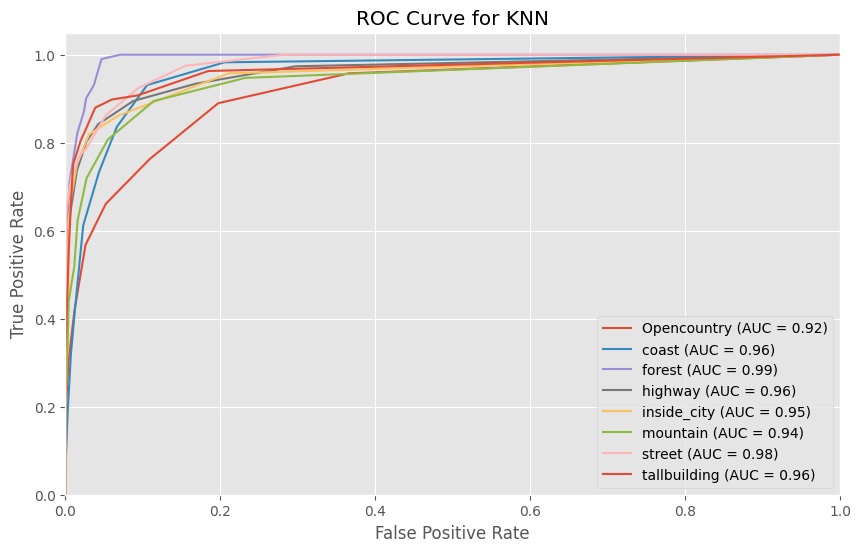

In [ ]:
print("ROC Curve (Dense SIFT):")
utils.plot_roc_curve(visual_words_dense_test, test_labels, base_d_knn, "KNN")

------------------------------------------------------------------------------------------------------------------------------------------------

### Logistic Regression
We build a logisitc regression classifier and train it with the train descriptors

In [43]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model
logistic_reg = LogisticRegression(max_iter=10000)  

# Convert string labels to numerical labels
label_mapping = {label: idx for idx, label in enumerate(np.unique(train_labels))}
train_labels_numeric = np.array([label_mapping[label] for label in train_labels])

# Train the model
logistic_reg.fit(visual_words, train_labels_numeric)

base_logistic_reg = logistic_reg


# Make predictions on the test data
predictions_numeric = logistic_reg.predict(visual_words_test)
# Assuming you have a label_mapping dictionary that maps numerical labels to string labels
label_mapping_inverse = {idx: label for label, idx in label_mapping.items()}
# Convert numerical predictions back to string labels
predictions = np.array([label_mapping_inverse[idx] for idx in predictions_numeric])
accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy for logistic regression (SIFT): {100*accuracy}")

Accuracy for logistic regression (SIFT): 13.630731102850064


#### Dimensionality reduction, with PCA and LDA
##### PCA

In [ ]:
# Apply PCA and Logistic Regression for standard descriptors
if standard_descriptor:
    print('PCA and Logistic Regression for standard descriptors:')
    apply_dimensionality_reduction_and_classification(visual_words, visual_words_test, train_labels, test_labels, 'pca', model=LogisticRegression(max_iter=10000))

# Apply PCA and Logistic Regression for dense descriptors
if dense_descriptor:
    print('PCA and Logistic Regression for dense descriptors:')
    apply_dimensionality_reduction_and_classification(visual_words_dense, visual_words_dense_test, train_labels, test_labels, 'pca', model=LogisticRegression(max_iter=10000))

PCA and Logistic Regression for standard descriptors:
    -> Accuracy (PCA): 68.53%
PCA and Logistic Regression for dense descriptors:
    -> Accuracy (PCA): 80.05%


##### LDA

In [ ]:
# Apply LDA and Logistic Regression for standard descriptors
if standard_descriptor:
    print('LDA and Logistic Regression for standard descriptors:')
    apply_dimensionality_reduction_and_classification(visual_words, visual_words_test, train_labels, test_labels, 'lda', model=LogisticRegression(max_iter=10000))

# Apply LDA and Logistic Regression for dense descriptors
if dense_descriptor:
    print('LDA and Logistic Regression for dense descriptors:')
    apply_dimensionality_reduction_and_classification(visual_words_dense, visual_words_dense_test, train_labels, test_labels, 'lda', model=LogisticRegression(max_iter=10000))

LDA and Logistic Regression for standard descriptors:
    -> Accuracy (LDA): 64.56%
LDA and Logistic Regression for dense descriptors:
    -> Accuracy (LDA): 84.01%


#### Cross-Validation

In [45]:

# Perform cross-validation
cv_scores_logistic = cross_val_score(logistic_reg, visual_words, train_labels, cv=5)  # You can adjust the number of folds (cv) as needed

# Print the cross-validation scores
print("Logistic Regression Cross-Validation Scores:")
print(cv_scores_logistic)
print(f"Mean Accuracy: {np.mean(cv_scores_logistic) * 100:.2f}%")


Logistic Regression Cross-Validation Scores:
[0.12997347 0.125      0.11702128 0.11968085 0.15159574]
Mean Accuracy: 12.87%


Cross-Validate all Logistic Regression combinations:

In [ ]:
print("\nMean cross-validation SIFT + Logistic Regression + L2 Norm:", f"{np.mean(cross_val_score(logistic_reg, visual_words_test_l2, test_labels, cv=5))*100:.2f}%")
print("\nMean cross-validation Dense SIFT + Logistic Regression + L2 Norm:", f"{np.mean(cross_val_score(dense_logistic_reg, visual_words_dense_test_l2, test_labels, cv=5))*100:.2f}%")
print("\nMean cross-validation SIFT + Logistic Regression + Standard Scaling:", f"{np.mean(cross_val_score(logistic_reg, visual_words_test_std_scaling, test_labels, cv=5))*100:.2f}%")
print("\nMean cross-validation Dense SIFT + Logistic Regression + Standard Scaling:", f"{np.mean(cross_val_score(dense_logistic_reg, visual_words_dense_test_std_scaling, test_labels, cv=5))*100:.2f}%")
print("\nMean cross-validation SIFT + Logistic Regression + Spatial Pyramid:", f"{np.mean(cross_val_score(logistic_reg, test_descriptors_sp, test_labels, cv=5))*100:.2f}%")
print("\nMean cross-validation Dense SIFT + Logistic Regression + Spatial Pyramid:", f"{np.mean(cross_val_score(dense_logistic_reg, test_descriptors_sp_dense, test_labels, cv=5))*100:.2f}%")


Mean cross-validation SIFT + Logistic Regression + L2 Norm: 56.27%

Mean cross-validation Dense SIFT + Logistic Regression + L2 Norm: 75.96%

Mean cross-validation SIFT + Logistic Regression + Standard Scaling: 59.61%

Mean cross-validation Dense SIFT + Logistic Regression + Standard Scaling: 75.47%

Mean cross-validation SIFT + Logistic Regression + Spatial Pyramid: 69.52%

Mean cross-validation Dense SIFT + Logistic Regression + Spatial Pyramid: 80.92%


### Experimentation with Logistic Regression

Confusion Matrix (SIFT):


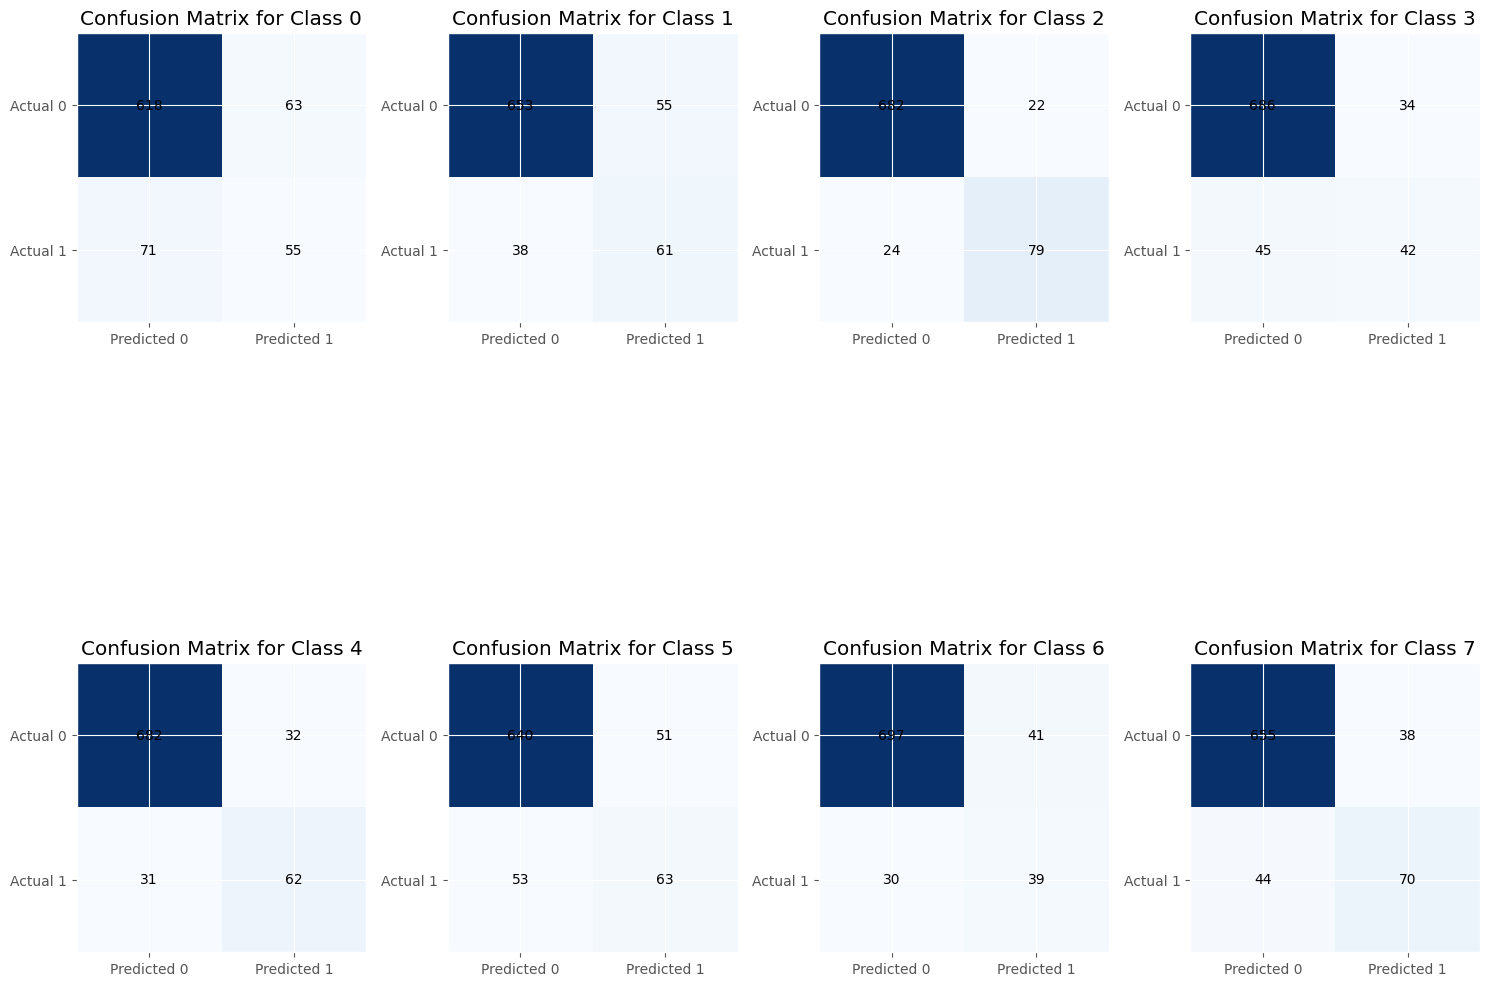

Confusion Matrix (Dense SIFT):


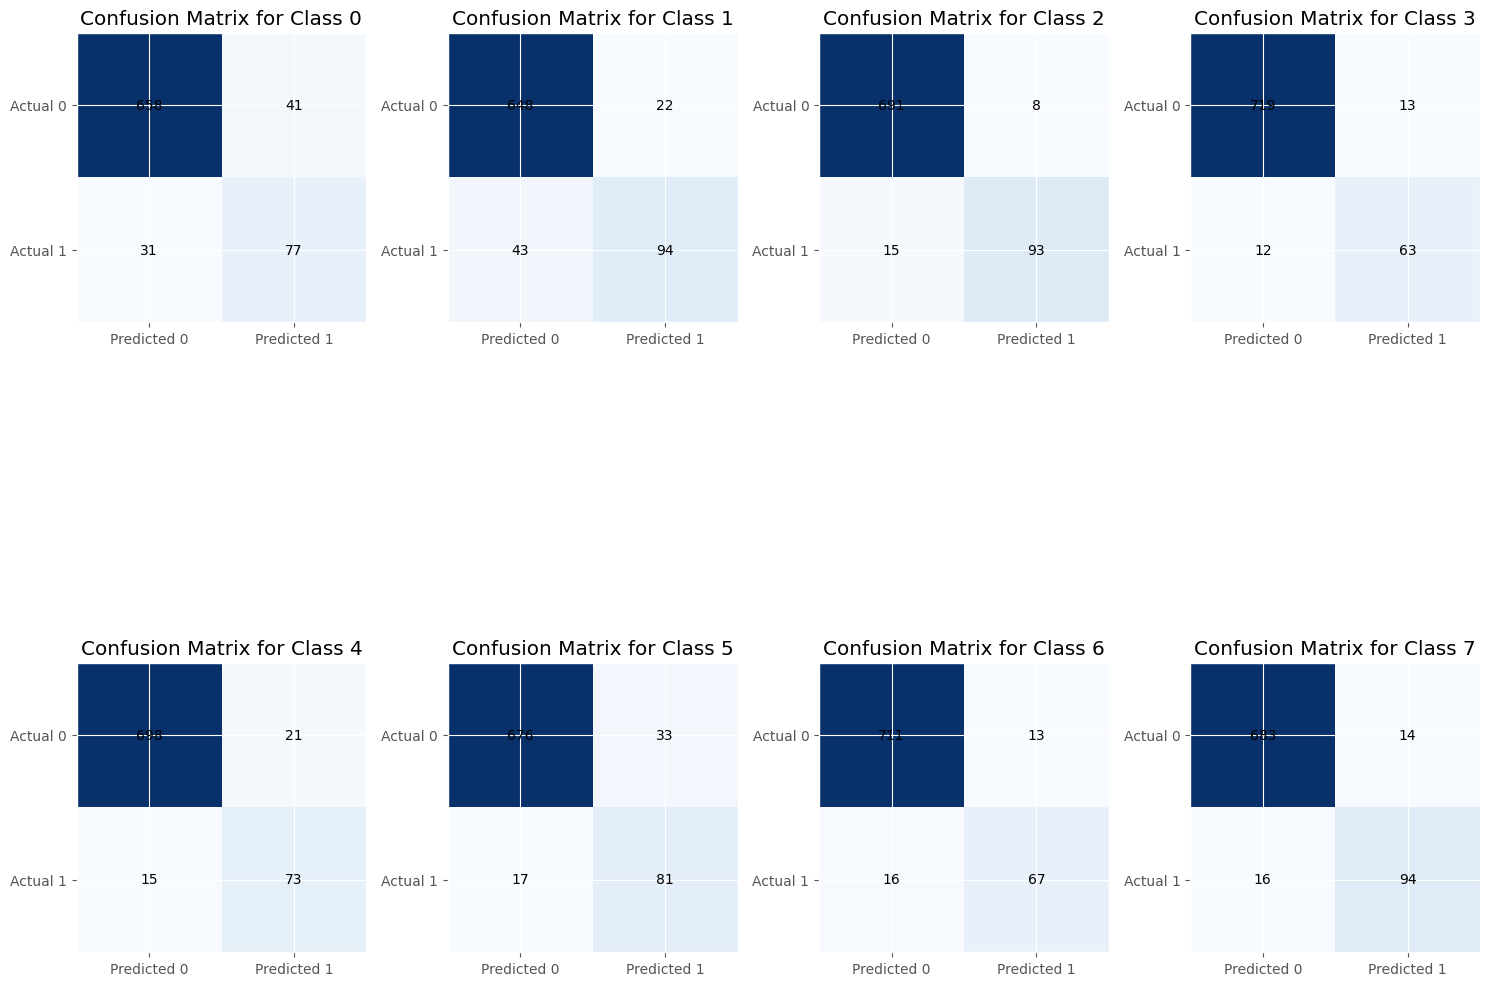

In [ ]:
print("Confusion Matrix (SIFT):")
utils.display_multilabel_confusion_matrix(visual_words_test, test_labels, logistic_reg, mapping=label_mapping)

print("Confusion Matrix (Dense SIFT):")
utils.display_multilabel_confusion_matrix(visual_words_dense_test, test_labels, dense_logistic_reg, mapping=label_mapping)

In [ ]:
predictions_numeric = logistic_reg.predict(visual_words_test)
label_mapping_inverse = {idx: label for label, idx in label_mapping.items()}
predictions = np.array([label_mapping_inverse[idx] for idx in predictions_numeric])
report = classification_report(predictions, test_labels)
print("Classification Report (SIFT):\n", report)

Classification Report (SIFT):
               precision    recall  f1-score   support

 Opencountry       0.47      0.44      0.45       126
       coast       0.53      0.62      0.57        99
      forest       0.78      0.77      0.77       103
     highway       0.55      0.48      0.52        87
 inside_city       0.66      0.67      0.66        93
    mountain       0.55      0.54      0.55       116
      street       0.49      0.57      0.52        69
tallbuilding       0.65      0.61      0.63       114

    accuracy                           0.58       807
   macro avg       0.58      0.59      0.58       807
weighted avg       0.59      0.58      0.58       807



In [ ]:
predictions_numeric = dense_logistic_reg.predict(visual_words_dense_test)
label_mapping_inverse = {idx: label for label, idx in label_mapping.items()}
predictions = np.array([label_mapping_inverse[idx] for idx in predictions_numeric])
report = classification_report(predictions, test_labels)
print("Classification Report (Dense SIFT):\n", report)

Classification Report (Dense SIFT):
               precision    recall  f1-score   support

 Opencountry       0.65      0.71      0.68       108
       coast       0.81      0.69      0.74       137
      forest       0.92      0.86      0.89       108
     highway       0.83      0.84      0.83        75
 inside_city       0.78      0.83      0.80        88
    mountain       0.71      0.83      0.76        98
      street       0.84      0.81      0.82        83
tallbuilding       0.87      0.85      0.86       110

    accuracy                           0.80       807
   macro avg       0.80      0.80      0.80       807
weighted avg       0.80      0.80      0.80       807



Logistic Regression with L2 Normalization accuracies:

In [ ]:
print("SIFT + Logistic Regression + L2 Norm")
utils.fit_predict_and_score(logistic_reg, visual_words_l2, train_labels, visual_words_test_l2, test_labels)
print("\nDense SIFT + Logistic Regression + L2 Norm")
utils.fit_predict_and_score(dense_logistic_reg, visual_words_dense_l2, train_labels, visual_words_dense_test_l2, test_labels)
print("\nSIFT + Logistic Regression + L2 Norm + PCA")
apply_dimensionality_reduction_and_classification(visual_words_l2, visual_words_test_l2, train_labels, test_labels, 'pca', model=logistic_reg)
print("\nDense SIFT + Logistic Regression + L2 Norm + PCA")
apply_dimensionality_reduction_and_classification(visual_words_dense_l2, visual_words_dense_test_l2, train_labels, test_labels, 'pca', model=dense_logistic_reg)
print("\nSIFT + Logistic Regression + L2 Norm + LDA")
apply_dimensionality_reduction_and_classification(visual_words_l2, visual_words_test_l2, train_labels, test_labels, 'lda', model=logistic_reg)
print("\nDense SIFT + Logistic Regression + L2 Norm + LDA")
apply_dimensionality_reduction_and_classification(visual_words_dense_l2, visual_words_dense_test_l2, train_labels, test_labels, 'lda', model=dense_logistic_reg)

SIFT + Logistic Regression + L2 Norm


c:\Users\maria\Desktop\C3\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


    -> F1-Score: 59.09%
    -> Accuracy: 59.23%
    -> Precision: 59.34%
    -> Recall: 59.10%

Dense SIFT + Logistic Regression + L2 Norm
    -> F1-Score: 78.34%
    -> Accuracy: 77.82%
    -> Precision: 78.35%
    -> Recall: 78.43%

SIFT + Logistic Regression + L2 Norm + PCA
    -> Accuracy (PCA): 66.91%

Dense SIFT + Logistic Regression + L2 Norm + PCA
    -> Accuracy (PCA): 79.68%

SIFT + Logistic Regression + L2 Norm + LDA
    -> Accuracy (LDA): 66.54%

Dense SIFT + Logistic Regression + L2 Norm + LDA
    -> Accuracy (LDA): 82.53%


Logistic Regression with Standard Scaling accuracies:

In [ ]:
print("SIFT + Logistic Regression + Standard Scaling")
utils.fit_predict_and_score(logistic_reg, visual_words_std_scaling, train_labels, visual_words_test_std_scaling, test_labels)
print("\nDense SIFT + Logistic Regression + Standard Scaling")
utils.fit_predict_and_score(dense_logistic_reg, visual_words_dense_std_scaling, train_labels, visual_words_dense_test_std_scaling, test_labels)
print("\nSIFT + Logistic Regression + Standard Scaling + PCA")
apply_dimensionality_reduction_and_classification(visual_words_std_scaling, visual_words_test_std_scaling, train_labels, test_labels, 'pca', model=logistic_reg)
print("\nDense SIFT + Logistic Regression + Standard Scaling + PCA")
apply_dimensionality_reduction_and_classification(visual_words_dense_std_scaling, visual_words_dense_test_std_scaling, train_labels, test_labels, 'pca', model=dense_logistic_reg)
print("\nSIFT + Logistic Regression + Standard Scaling + LDA")
apply_dimensionality_reduction_and_classification(visual_words_std_scaling, visual_words_test_std_scaling, train_labels, test_labels, 'lda', model=logistic_reg)
print("\nDense SIFT + Logistic Regression + Standard Scaling + LDA")
apply_dimensionality_reduction_and_classification(visual_words_dense_std_scaling, visual_words_dense_test_std_scaling, train_labels, test_labels, 'lda', model=dense_logistic_reg)

SIFT + Logistic Regression + Standard Scaling
    -> F1-Score: 58.05%
    -> Accuracy: 58.24%
    -> Precision: 58.19%
    -> Recall: 58.14%

Dense SIFT + Logistic Regression + Standard Scaling
    -> F1-Score: 76.44%
    -> Accuracy: 76.46%
    -> Precision: 76.46%
    -> Recall: 76.60%

SIFT + Logistic Regression + Standard Scaling + PCA
    -> Accuracy (PCA): 68.28%

Dense SIFT + Logistic Regression + Standard Scaling + PCA
    -> Accuracy (PCA): 78.44%

SIFT + Logistic Regression + Standard Scaling + LDA
    -> Accuracy (LDA): 66.42%

Dense SIFT + Logistic Regression + Standard Scaling + LDA
    -> Accuracy (LDA): 84.26%


Logistic Regression with Spatial Pyramids accuracies:

In [ ]:
print("SIFT + Logistic Regression + Spatial Pyramid")
utils.fit_predict_and_score(logistic_reg, train_descriptors_sp, train_labels, test_descriptors_sp, test_labels)
print("\nDense SIFT + Logistic Regression + Spatial Pyramid")
utils.fit_predict_and_score(dense_logistic_reg, train_descriptors_sp_dense, train_labels, test_descriptors_sp_dense, test_labels)
print("\nSIFT + SVM + Logistic Regression + PCA")
apply_dimensionality_reduction_and_classification(train_descriptors_sp, test_descriptors_sp, train_labels, test_labels, 'pca', model=logistic_reg)
print("\nDense SIFT + Logistic Regression + Spatial Pyramid + PCA")
apply_dimensionality_reduction_and_classification(train_descriptors_sp_dense, test_descriptors_sp_dense, train_labels, test_labels, 'pca', model=dense_logistic_reg)
print("\nSIFT + Logistic Regression + Spatial Pyramid + LDA")
apply_dimensionality_reduction_and_classification(train_descriptors_sp, test_descriptors_sp, train_labels, test_labels, 'lda', model=logistic_reg)
print("\nDense SIFT + Logistic Regression + Spatial Pyramid + LDA")
apply_dimensionality_reduction_and_classification(train_descriptors_sp_dense, test_descriptors_sp_dense, train_labels, test_labels, 'lda', model=dense_logistic_reg)

SIFT + Logistic Regression + Spatial Pyramid
    -> F1-Score: 75.13%
    -> Accuracy: 74.97%
    -> Precision: 75.40%
    -> Recall: 75.00%

Dense SIFT + Logistic Regression + Spatial Pyramid
    -> F1-Score: 84.79%
    -> Accuracy: 84.51%
    -> Precision: 84.95%
    -> Recall: 84.71%

SIFT + SVM + Logistic Regression + PCA
    -> Accuracy (PCA): 73.73%

Dense SIFT + Logistic Regression + Spatial Pyramid + PCA
    -> Accuracy (PCA): 81.41%

SIFT + Logistic Regression + Spatial Pyramid + LDA
    -> Accuracy (LDA): 28.38%

Dense SIFT + Logistic Regression + Spatial Pyramid + LDA
    -> Accuracy (LDA): 57.50%


##### ROC curves for each class

ROC Curve (SIFT):


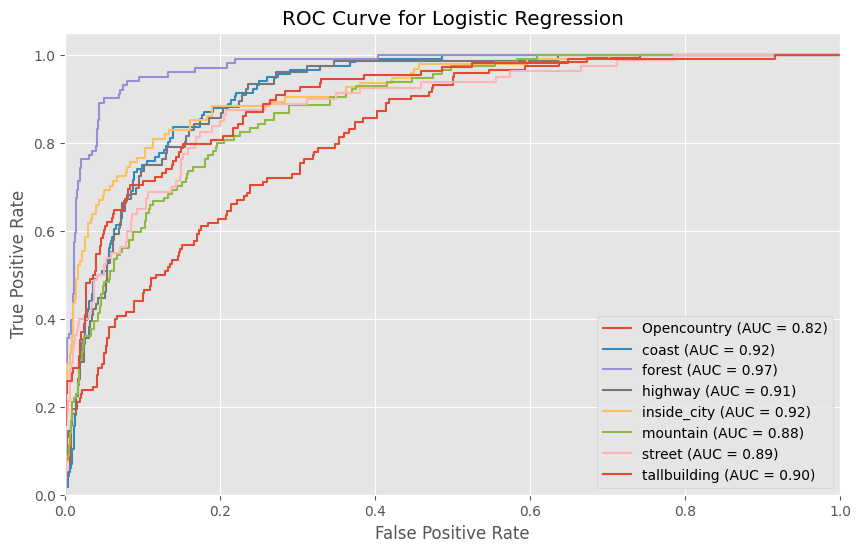

In [ ]:
print("ROC Curve (SIFT):")
utils.plot_roc_curve(visual_words_test, test_labels, base_logistic_reg, "Logistic Regression")

ROC Curve (Dense SIFT):


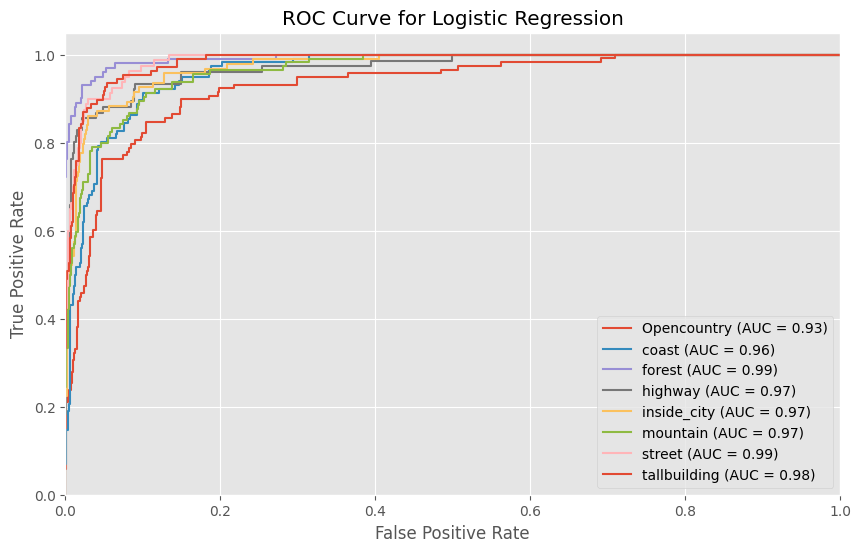

In [ ]:
print("ROC Curve (Dense SIFT):")
utils.plot_roc_curve(visual_words_dense_test, test_labels, base_dense_logistic_reg, "Logistic Regression")

------------------------------------------------------------------------------------------------------------------------------------------------

### Support Vector Machine (SVM)
We build a SVM classifier and train it with the train descriptors. Since we performed a study to get the best parameters for SVM, we can get the parameters from the results obtained use those for the model.

C:\Users\maria\AppData\Local\Temp\ipykernel_9140\3496304890.py:5: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(loaded_study)
[W 2024-01-11 21:51:55,111] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


Best Hyperparameters: {'C': 0.01, 'kernel': 'linear', 'gamma': 1}


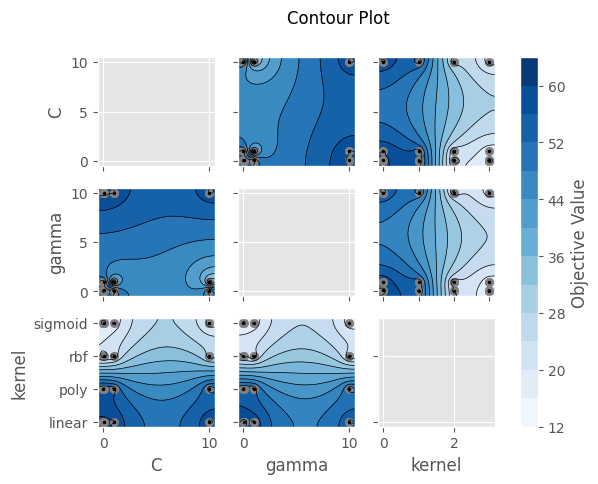

In [38]:
# Load the existing study from the database
loaded_study = optuna.load_study(
    study_name="svm_experiment", storage="sqlite:///svm.db"
)
optuna.visualization.matplotlib.plot_contour(loaded_study)

# Get the best hyperparameters
best_params = loaded_study.best_params
C = best_params['C']
kernel = best_params['kernel']
gamma = best_params['gamma']
print("Best Hyperparameters:", best_params)

In [39]:
svm = SVC(C=C, kernel=kernel, gamma=gamma, random_state=42)
svm.fit(visual_words, train_labels) 
base_svm = svm


In [40]:
accuracy = 100*svm.score(visual_words_test, test_labels)
print(f"SIFT accuracy: {accuracy}")

SIFT accuracy: 14.622057001239158


We obtain a pretty good accuracy with Dense SIFT, but let's try what we obtain when applying PCA and LDA.

#### Dimensionality reduction, with PCA and LDA

##### PCA

In [ ]:
# Apply PCA and SVM for standard descriptors
if standard_descriptor:
    print('PCA and SVM for standard descriptors:')
    apply_dimensionality_reduction_and_classification(visual_words, visual_words_test, train_labels, test_labels, 'pca', model=SVC(C=C, kernel=kernel, gamma=gamma, random_state=42))

# Apply PCA and SVM for dense descriptors
if dense_descriptor:
    print('PCA and SVM for dense descriptors:')
    apply_dimensionality_reduction_and_classification(visual_words_dense, visual_words_dense_test, train_labels, test_labels, 'pca', model=SVC(C=C, kernel=kernel, gamma=gamma, random_state=42))

PCA and SVM for standard descriptors:
    -> Accuracy (PCA): 71.38%
PCA and SVM for dense descriptors:
    -> Accuracy (PCA): 80.92%


The results obtained are better for both standard and dense cases, although the latter is slightly better only.

##### LDA

In [ ]:
# Apply LDA and SVM for standard descriptors
if standard_descriptor:
    print('LDA and SVM for standard descriptors:')
    apply_dimensionality_reduction_and_classification(visual_words, visual_words_test, train_labels, test_labels, 'lda', model=SVC(C=C, kernel=kernel, gamma=gamma, random_state=42))

# Apply LDA and SVM for dense descriptors
if dense_descriptor:
    print('LDA and SVM for dense descriptors:')
    apply_dimensionality_reduction_and_classification(visual_words_dense, visual_words_dense_test, train_labels, test_labels, 'lda', model=SVC(C=C, kernel=kernel, gamma=gamma, random_state=42))

LDA and SVM for standard descriptors:
    -> Accuracy (LDA): 65.30%
LDA and SVM for dense descriptors:
    -> Accuracy (LDA): 83.89%


The results for LDA and SVM are significantly better than the previous ones with SVM for the case of dense SIFT, however for the standard we can see that we obtain worse results.

##### Cross Validation

In [ ]:
if standard_descriptor:
    # Perform cross-validation
    cv_scores_svm = cross_val_score(svm, visual_words, train_labels, cv=5)  # You can adjust the number of folds (cv) as needed

    # Print the cross-validation scores
    print("SVM Cross-Validation Scores:")
    print(cv_scores_svm)
    print(f"Mean Accuracy: {np.mean(cv_scores_svm) * 100:.2f}%")

if dense_descriptor:
    # Perform cross-validation
    dense_cv_scores_svm = cross_val_score(dense_svm, visual_words_dense, train_labels, cv=5)  # You can adjust the number of folds (cv) as needed

    # Print the cross-validation scores
    print("SVM Cross-Validation Scores:")
    print(dense_cv_scores_svm)
    print(f"Mean Accuracy: {np.mean(dense_cv_scores_svm) * 100:.2f}%")

SVM Cross-Validation Scores:
[0.54376658 0.59308511 0.63829787 0.65957447 0.59840426]
Mean Accuracy: 60.66%
SVM Cross-Validation Scores:
[0.76392573 0.77925532 0.78723404 0.83510638 0.76329787]
Mean Accuracy: 78.58%


Cross-Validate all SVM combinations:

In [ ]:
print("\nMean cross-validation SIFT + SVM + Standard Scaling:", f"{np.mean(cross_val_score(SVC(C=C, kernel=kernel, gamma=gamma, random_state=42), visual_words_test_std_scaling, test_labels, cv=5))*100:.2f}%")
print("\nMean cross-validation Dense SIFT + SVM + Standard Scaling:", f"{np.mean(cross_val_score(SVC(C=C, kernel=kernel, gamma=gamma, random_state=42), visual_words_dense_test_std_scaling, test_labels, cv=5))*100:.2f}%")
print("\nMean cross-validation SIFT + SVM + L2 Norm:", f"{np.mean(cross_val_score(SVC(C=C, kernel=kernel, gamma=gamma, random_state=42), visual_words_test_l2, test_labels, cv=5))*100:.2f}%")
print("\nMean cross-validation Dense SIFT + SVM + L2 Norm:", f"{np.mean(cross_val_score(SVC(C=C, kernel=kernel, gamma=gamma, random_state=42), visual_words_dense_test_l2, test_labels, cv=5))*100:.2f}%")
print("\nMean cross-validation SIFT + SVM + Spatial Pyramid:", f"{np.mean(cross_val_score(SVC(C=C, kernel=kernel, gamma=gamma, random_state=42), test_descriptors_sp, test_labels, cv=5))*100:.2f}%")
print("\nMean cross-validation Dense SIFT + SVM + Spatial Pyramid:", f"{np.mean(cross_val_score(SVC(C=C, kernel=kernel, gamma=gamma, random_state=42), test_descriptors_sp_dense, test_labels, cv=5))*100:.2f}%")


Mean cross-validation SIFT + SVM + Standard Scaling: 61.09%

Mean cross-validation Dense SIFT + SVM + Standard Scaling: 75.97%

Mean cross-validation SIFT + SVM + L2 Norm: 55.89%

Mean cross-validation Dense SIFT + SVM + L2 Norm: 76.58%

Mean cross-validation SIFT + SVM + Spatial Pyramid: 67.91%

Mean cross-validation Dense SIFT + SVM + Spatial Pyramid: 81.41%


We see that we obtain worse values in average than the previous experiments with PCA and LDA.

### Experimentation with SVM

First, apply LDA because it yields the best results.

In [ ]:
lda = LinearDiscriminantAnalysis()
dense_lda = LinearDiscriminantAnalysis()

visual_words = lda.fit_transform(visual_words, train_labels)
visual_words_test = lda.transform(visual_words_test)
visual_words_dense = dense_lda.fit_transform(visual_words_dense, train_labels)
visual_words_dense_test = dense_lda.transform(visual_words_dense_test)

svm = SVC(C=C, kernel=kernel, gamma=gamma, random_state=42)
svm.fit(visual_words, train_labels)

dense_svm = SVC(C=C, kernel=kernel, gamma=gamma, random_state=42)
dense_svm.fit(visual_words_dense, train_labels)
print("Models loaded!")

Models loaded!


Confusion Matrix (SIFT):


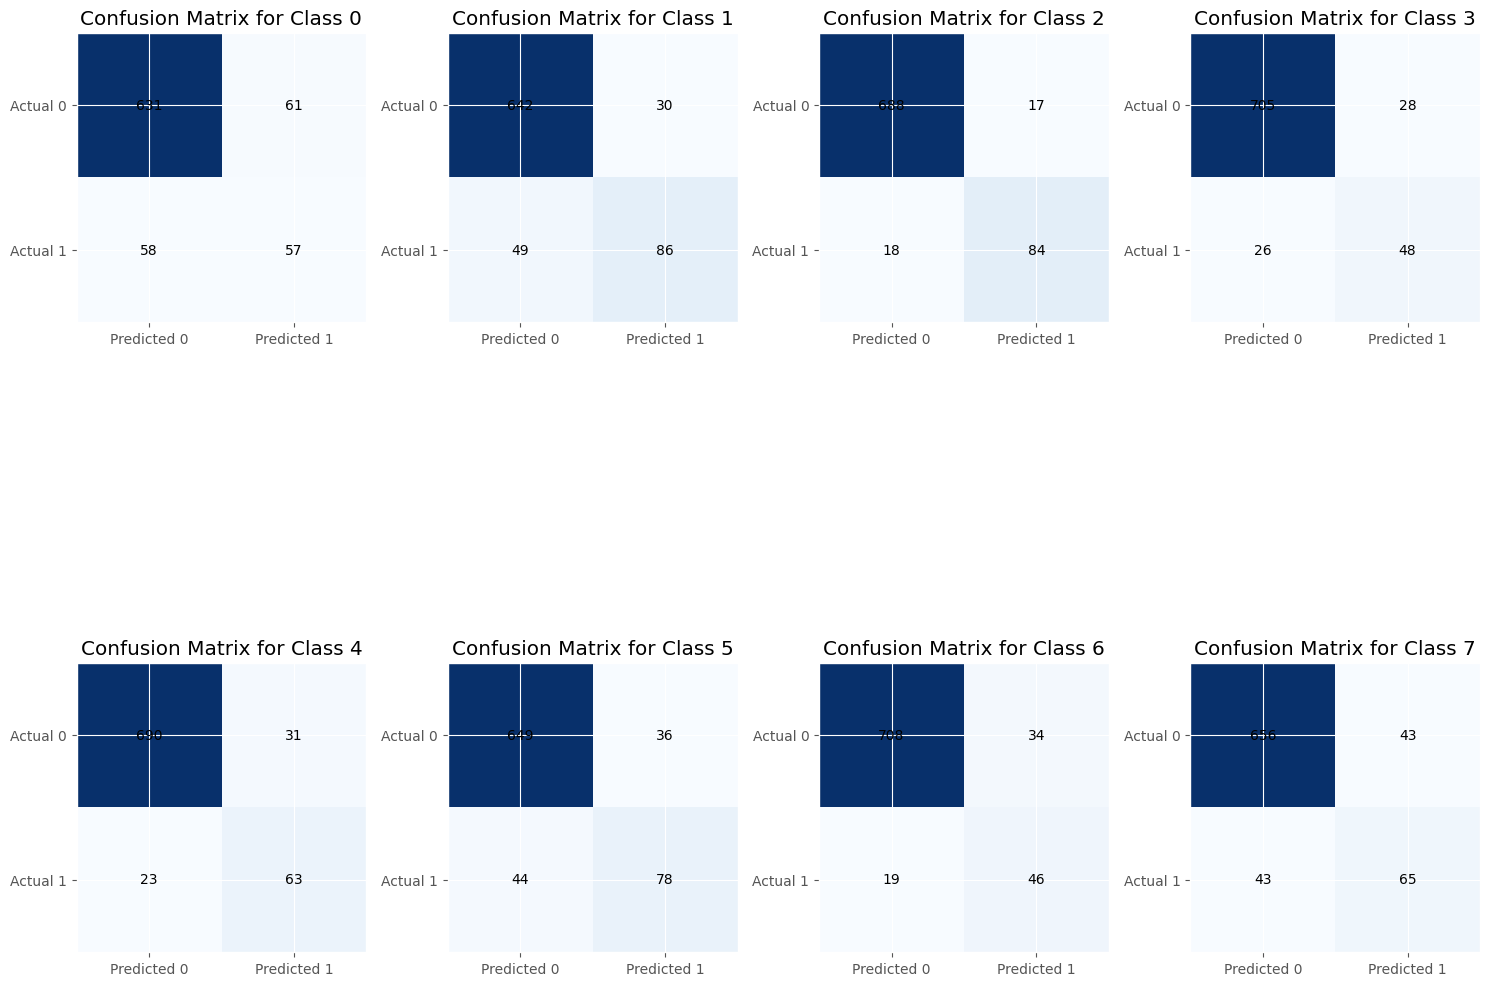

Confusion Matrix (Dense SIFT):


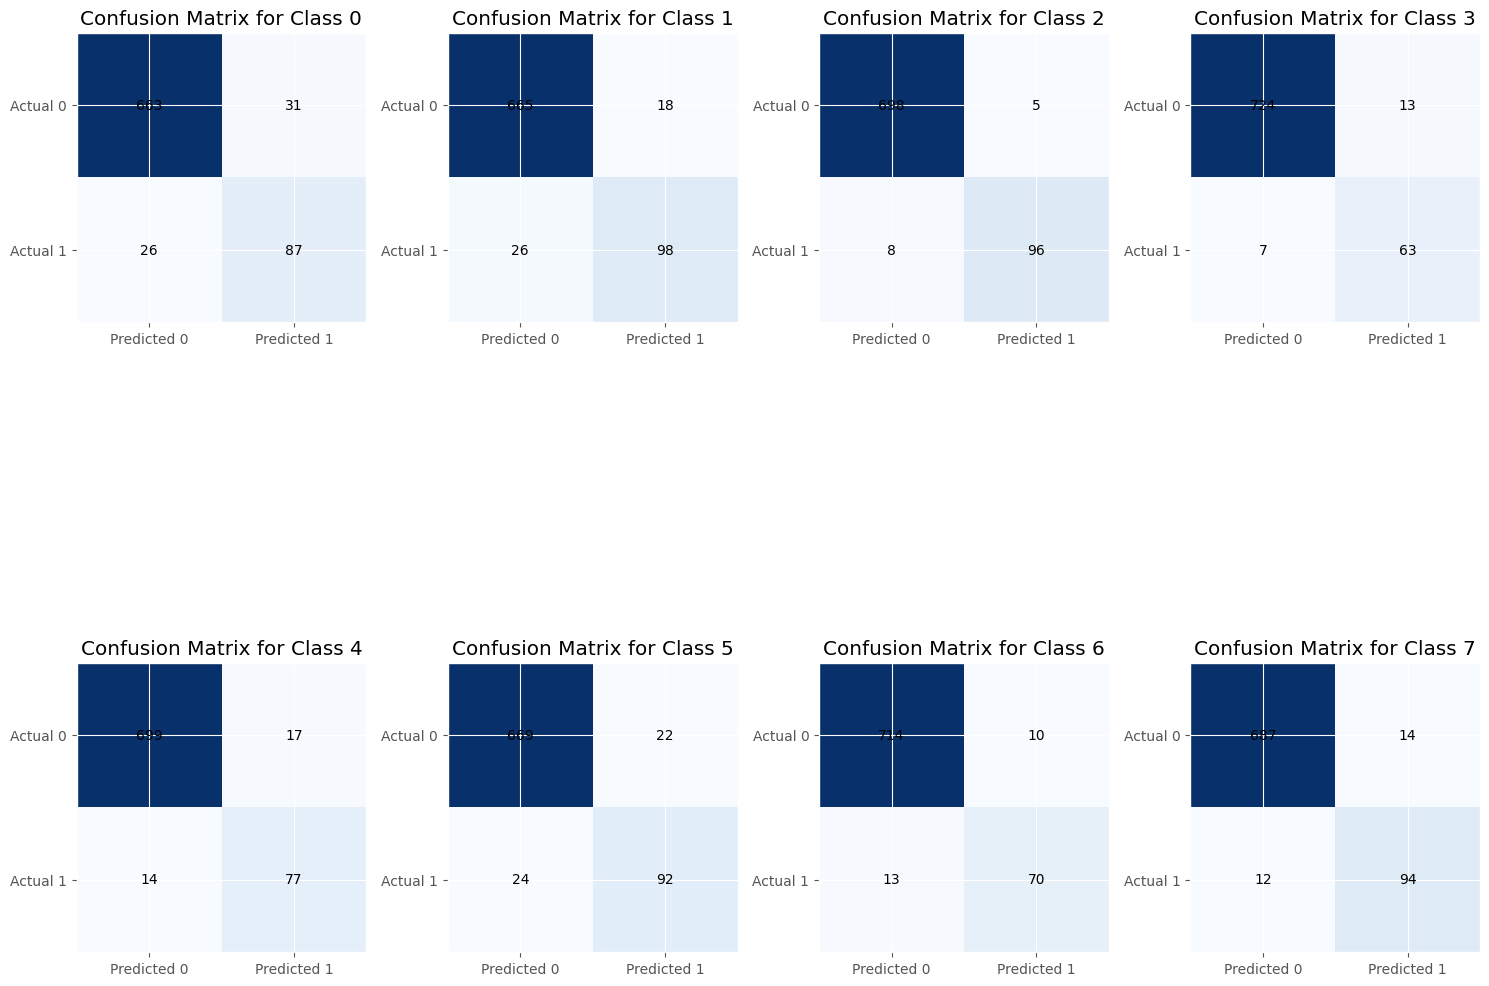

In [ ]:
print("Confusion Matrix (SIFT):")
utils.display_multilabel_confusion_matrix(visual_words_test, test_labels, svm)

print("Confusion Matrix (Dense SIFT):")
utils.display_multilabel_confusion_matrix(visual_words_dense_test, test_labels, dense_svm)

In [ ]:
report = classification_report(svm.predict(visual_words_test), test_labels)
print("Classification Report (SIFT):\n", report)

Classification Report (SIFT):
               precision    recall  f1-score   support

 Opencountry       0.48      0.50      0.49       115
       coast       0.74      0.64      0.69       135
      forest       0.83      0.82      0.83       102
     highway       0.63      0.65      0.64        74
 inside_city       0.67      0.73      0.70        86
    mountain       0.68      0.64      0.66       122
      street       0.57      0.71      0.63        65
tallbuilding       0.60      0.60      0.60       108

    accuracy                           0.65       807
   macro avg       0.65      0.66      0.65       807
weighted avg       0.66      0.65      0.65       807



In [ ]:
report = classification_report(dense_svm.predict(visual_words_dense_test), test_labels)
print("Classification Report (Dense SIFT):\n", report)

Classification Report (Dense SIFT):
               precision    recall  f1-score   support

 Opencountry       0.74      0.77      0.75       113
       coast       0.84      0.79      0.82       124
      forest       0.95      0.92      0.94       104
     highway       0.83      0.90      0.86        70
 inside_city       0.82      0.85      0.83        91
    mountain       0.81      0.79      0.80       116
      street       0.88      0.84      0.86        83
tallbuilding       0.87      0.89      0.88       106

    accuracy                           0.84       807
   macro avg       0.84      0.84      0.84       807
weighted avg       0.84      0.84      0.84       807



In [ ]:
svc_std_scaling = SVC(C=C, kernel=kernel, gamma=gamma, random_state=42)
svc_std_scaling_dense = SVC(C=C, kernel=kernel, gamma=gamma, random_state=42)
svc_l2 = SVC(C=C, kernel=kernel, gamma=gamma, random_state=42)
svc_l2_dense = SVC(C=C, kernel=kernel, gamma=gamma, random_state=42)
svc_spatial_pyramid = SVC(C=C, kernel=kernel, gamma=gamma, random_state=42)
svc_spatial_pyramid_dense = SVC(C=C, kernel=kernel, gamma=gamma, random_state=42)

In [ ]:
print("SIFT + SVM + Standard Scaling\n")
utils.fit_predict_and_score(svc_std_scaling, visual_words_std_scaling, train_labels, visual_words_test_std_scaling, test_labels)
print("\nDense SIFT + SVM + Standard Scaling\n")
utils.fit_predict_and_score(svc_std_scaling_dense, visual_words_dense_std_scaling, train_labels, visual_words_dense_test_std_scaling, test_labels)
print("\nSIFT + SVM + Standard Scaling + PCA\n")
apply_dimensionality_reduction_and_classification(visual_words_std_scaling, visual_words_test_std_scaling, train_labels, test_labels, 'pca', model=SVC(C=C, kernel=kernel, gamma=gamma, random_state=42))
print("\nDense SIFT + SVM + Standard Scaling + PCA\n")
apply_dimensionality_reduction_and_classification(visual_words_dense_std_scaling, visual_words_dense_test_std_scaling, train_labels, test_labels, 'pca', model=SVC(C=C, kernel=kernel, gamma=gamma, random_state=42))
print("\nSIFT + SVM + Standard Scaling + LDA\n")
apply_dimensionality_reduction_and_classification(visual_words_std_scaling, visual_words_test_std_scaling, train_labels, test_labels, 'lda', model=SVC(C=C, kernel=kernel, gamma=gamma, random_state=42))
print("\nDense SIFT + SVM + Standard Scaling + LDA\n")
apply_dimensionality_reduction_and_classification(visual_words_dense_std_scaling, visual_words_dense_test_std_scaling, train_labels, test_labels, 'lda', model=SVC(C=C, kernel=kernel, gamma=gamma, random_state=42))

SIFT + SVM + Standard Scaling

    -> F1-Score: 66.64%
    -> Accuracy: 66.79%
    -> Precision: 67.20%
    -> Recall: 66.62%

Dense SIFT + SVM + Standard Scaling

    -> F1-Score: 79.31%
    -> Accuracy: 79.31%
    -> Precision: 79.59%
    -> Recall: 79.26%

SIFT + SVM + Standard Scaling + PCA

    -> Accuracy (PCA): 70.76%

Dense SIFT + SVM + Standard Scaling + PCA

    -> Accuracy (PCA): 78.69%

SIFT + SVM + Standard Scaling + LDA

    -> Accuracy (LDA): 66.67%

Dense SIFT + SVM + Standard Scaling + LDA

    -> Accuracy (LDA): 83.52%


In [ ]:
print("SIFT + SVM + L2 Norm\n")
utils.fit_predict_and_score(svc_l2, visual_words_l2, train_labels, visual_words_test_l2, test_labels)
print("\nDense SIFT + SVM + L2 Norm\n")
utils.fit_predict_and_score(svc_l2_dense, visual_words_dense_l2, train_labels, visual_words_dense_test_l2, test_labels)
print("\nSIFT + SVM + L2 Norm + PCA\n")
apply_dimensionality_reduction_and_classification(visual_words_l2, visual_words_test_l2, train_labels, test_labels, 'pca', model=SVC(C=C, kernel=kernel, gamma=gamma, random_state=42))
print("\nDense SIFT + SVM + L2 Norm + PCA\n")
apply_dimensionality_reduction_and_classification(visual_words_dense_l2, visual_words_dense_test_l2, train_labels, test_labels, 'pca', model=SVC(C=C, kernel=kernel, gamma=gamma, random_state=42))
print("\nSIFT + SVM + L2 Norm + LDA\n")
apply_dimensionality_reduction_and_classification(visual_words_l2, visual_words_test_l2, train_labels, test_labels, 'lda', model=SVC(C=C, kernel=kernel, gamma=gamma, random_state=42))
print("\nDense SIFT + SVM + L2 Norm + LDA\n")
apply_dimensionality_reduction_and_classification(visual_words_dense_l2, visual_words_dense_test_l2, train_labels, test_labels, 'lda', model=SVC(C=C, kernel=kernel, gamma=gamma, random_state=42))

SIFT + SVM + L2 Norm

    -> F1-Score: 63.90%
    -> Accuracy: 64.06%
    -> Precision: 64.32%
    -> Recall: 63.89%

Dense SIFT + SVM + L2 Norm

    -> F1-Score: 80.12%
    -> Accuracy: 79.55%
    -> Precision: 80.68%
    -> Recall: 79.89%

SIFT + SVM + L2 Norm + PCA

    -> Accuracy (PCA): 65.30%

Dense SIFT + SVM + L2 Norm + PCA

    -> Accuracy (PCA): 79.55%

SIFT + SVM + L2 Norm + LDA

    -> Accuracy (LDA): 66.79%

Dense SIFT + SVM + L2 Norm + LDA

    -> Accuracy (LDA): 81.54%


In [ ]:
print("SIFT + SVM + Spatial Pyramid")
utils.fit_predict_and_score(svc_spatial_pyramid, train_descriptors_sp, train_labels, test_descriptors_sp, test_labels)
print("\nDense SIFT + SVM + Spatial Pyramid")
utils.fit_predict_and_score(svc_spatial_pyramid_dense, train_descriptors_sp_dense, train_labels, test_descriptors_sp_dense, test_labels)
print("\nSIFT + SVM + Spatial Pyramid + PCA")
apply_dimensionality_reduction_and_classification(train_descriptors_sp, test_descriptors_sp, train_labels, test_labels, 'pca', model=SVC(C=C, kernel=kernel, gamma=gamma, random_state=42))
print("\nDense SIFT + SVM + Spatial Pyramid + PCA")
apply_dimensionality_reduction_and_classification(train_descriptors_sp_dense, test_descriptors_sp_dense, train_labels, test_labels, 'pca', model=SVC(C=C, kernel=kernel, gamma=gamma, random_state=42))
print("\nSIFT + SVM + Spatial Pyramid + LDA")
apply_dimensionality_reduction_and_classification(train_descriptors_sp, test_descriptors_sp, train_labels, test_labels, 'lda', model=SVC(C=C, kernel=kernel, gamma=gamma, random_state=42))
print("\nDense SIFT + SVM + Spatial Pyramid + LDA")
apply_dimensionality_reduction_and_classification(train_descriptors_sp_dense, test_descriptors_sp_dense, train_labels, test_labels, 'lda', model=SVC(C=C, kernel=kernel, gamma=gamma, random_state=42))

SIFT + SVM + Spatial Pyramid
    -> F1-Score: 75.75%
    -> Accuracy: 75.71%
    -> Precision: 76.08%
    -> Recall: 75.74%

Dense SIFT + SVM + Spatial Pyramid
    -> F1-Score: 86.33%
    -> Accuracy: 86.00%
    -> Precision: 86.65%
    -> Recall: 86.21%

SIFT + SVM + Spatial Pyramid + PCA
    -> Accuracy (PCA): 74.85%

Dense SIFT + SVM + Spatial Pyramid + PCA
    -> Accuracy (PCA): 82.16%

SIFT + SVM + Spatial Pyramid + LDA
    -> Accuracy (LDA): 27.88%

Dense SIFT + SVM + Spatial Pyramid + LDA
    -> Accuracy (LDA): 49.57%


##### ROC curves for each class

ROC Curve (SIFT):


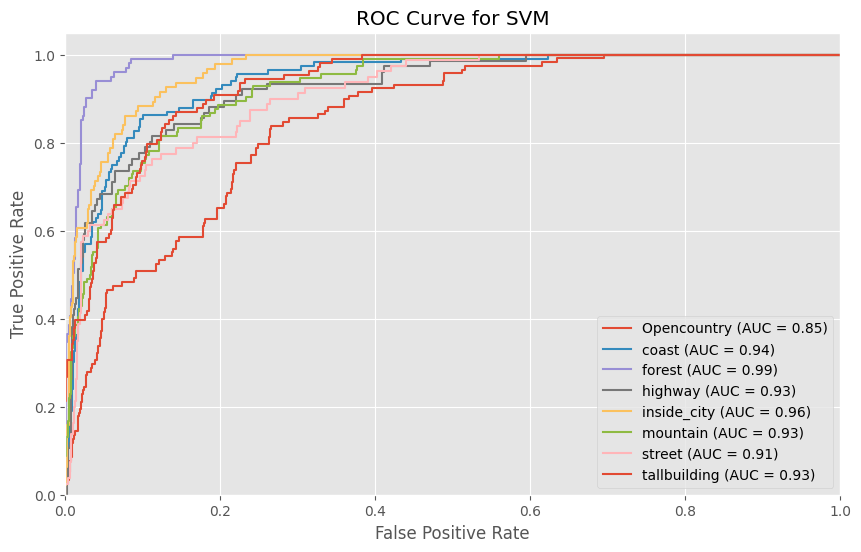

In [ ]:
print("ROC Curve (SIFT):")
utils.plot_roc_curve(visual_words_test, test_labels, base_svm, "SVM")

ROC Curve (Dense SIFT):


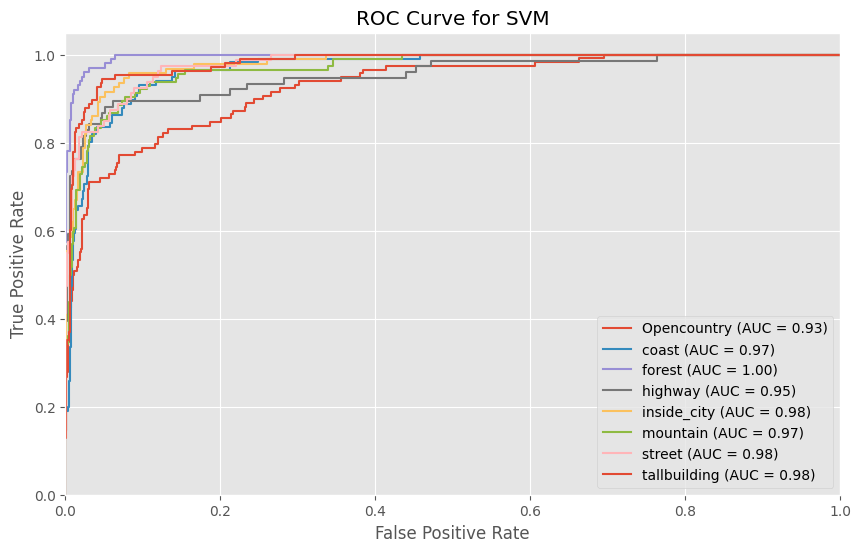

In [ ]:
print("ROC Curve (Dense SIFT):")
utils.plot_roc_curve(visual_words_dense_test, test_labels, base_dense_svm, "SVM")